In [0]:
import keras

In [0]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np


In [0]:
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, Activation,AveragePooling2D
from keras.optimizers import RMSprop

from keras import backend as K

num_classes = 10
epochs = 20

In [0]:
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [0]:
def create_pairs(x, digit_indices):
  pairs = []
  labels = []
  
  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
  
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)


def create_base_net(input_shape):
  
  input = Input(shape = input_shape)
  x = Conv2D(4, (5,5), activation = 'tanh')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(16, (5,5), activation = 'tanh')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Flatten()(x)
  x = Dense(10, activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()
  
  return model

In [58]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
# input_shape = (1, 28, 28)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)


(60000, 28, 28, 1)


In [59]:

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_net(input_shape)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 16)          1616      
_________________________________________________________________
average_pooling2d_12 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total para

In [0]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [61]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


W0930 08:28:56.880398 140243689490304 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0930 08:28:57.057897 140243689490304 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0930 08:28:57.067424 140243689490304 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 70s 642us/step - loss: 0.1118 - accuracy: 0.8743 - val_loss: 0.0770 - val_accuracy: 0.9331
Epoch 2/20
108400/108400 [==============================] - 69s 636us/step - loss: 0.0769 - accuracy: 0.9318 - val_loss: 0.0641 - val_accuracy: 0.9457
Epoch 3/20
108400/108400 [==============================] - 69s 634us/step - loss: 0.0657 - accuracy: 0.9467 - val_loss: 0.0567 - val_accuracy: 0.9543
Epoch 4/20
108400/108400 [==============================] - 68s 631us/step - loss: 0.0593 - accuracy: 0.9546 - val_loss: 0.0535 - val_accuracy: 0.9643
Epoch 5/20
108400/108400 [==============================] - 69s 633us/step - loss: 0.0550 - accuracy: 0.9596 - val_loss: 0.0493 - val_accuracy: 0.9640
Epoch 6/20
108400/108400 [==============================] - 69s 634us/step - loss: 0.0516 - accuracy: 0.9629 - val_loss: 0.0462 - val_accuracy: 0.9666
Epoch 7/20
108400/108400 [=================

In [62]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 97.02%
* Accuracy on test set: 96.99%


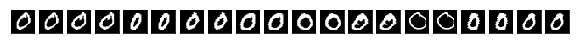

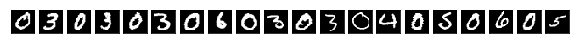

[0.18754582]
[1.3337698]
[0.07946939]
[1.4446068]
[0.14834742]
[1.1516165]
[0.23091802]
[1.071288]
[0.24541196]
[1.1644953]
[0.1913437]
[1.5523615]
[0.10591801]
[1.1770581]
[0.08508992]
[1.1937366]
[0.08196243]
[1.1436502]
[0.14193682]
[1.2800823]


In [107]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 20
import tensorflow as tf

# print(tr_pairs[1,0].shape)
# tr_pairs[1,0] = tr_pairs[1,0].reshape(28, 28)

im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

for i in range(number_of_items):
  print(y_pred[i])
# plt.figure(figsize=(20, 2))
# plt.imshow(im, cmap="gray")
# plt.show()